In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import itertools
import os

In [2]:
df = pd.read_pickle('../data/raw/emotions_training.pkl')

In [3]:
df=df.reset_index()

In [4]:
#Defining class for each emotion
df['labels'] = df['emotions'].factorize()[0]
df.head()


,index,text,emotions,labels
0,27383,i feel awful about it too because it s my job ...,sadness,0
1,110083,im alone i feel awful,sadness,0
2,140764,ive probably mentioned this before but i reall...,joy,1
3,100071,i was feeling a little low few days back,sadness,0
4,2837,i beleive that i am much more sensitive to oth...,love,2


In [5]:
uniquevalues = pd.unique(df[['emotions']].values.ravel())
df_unique=pd.DataFrame(uniquevalues,columns=['emotion'])


In [6]:
df_unique

,emotion
0,sadness
1,joy
2,love
3,anger
4,fear
5,surprise


In [7]:
df_unique.to_csv('../labels_prediction/emotions.csv',index=False)

In [12]:
#importing libraries for models and nlp tasks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.utils.class_weight import compute_class_weight

### TF-IDF Vectorization for models

In [8]:
tfidf_vectorizer = TfidfVectorizer()

In [9]:
y =df['labels']

In [10]:
#Train test split of the data
Xtrain, Xtest, ytrain, ytest = train_test_split(df['text'], y, test_size=0.3,random_state=1)
Xtrain_tfidf = tfidf_vectorizer.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vectorizer.transform(Xtest)

In [15]:
#pickle.dump(tfidf_vectorizer, open('../models/tfidf_vect.pkl', 'wb'))

##### Calculating classweights

In [13]:
weighting = compute_class_weight( class_weight ='balanced', classes =np.unique(y),y= y)
print(weighting)

[0.57323118 0.49244803 2.0104233  1.21199935 1.45598941 4.63987221]


In [15]:
class_weights = dict(zip(np.unique(y), weighting))


##### Logistic Regression

In [16]:
#Logistic Regression with One vs Rest
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=class_weights)
lr_mn.fit(Xtrain_tfidf, ytrain)

/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.5732311771614668, 1: 0.492448032967786,
                                 2: 2.010423298798017, 3: 1.2119993486516507,
                                 4: 1.4559894086742677, 5: 4.63987220589545},
                   multi_class='multinomial')

In [17]:
ypred_lr_mn=lr_mn.predict(Xtest_tfidf)

In [18]:
tr_acc_lr_mn = lr_mn.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_mn =  accuracy_score(ytest,ypred_lr_mn) * 100
print(tr_acc_lr_mn,test_acc_lr_mn)

91.00237861848194 90.08261158161592


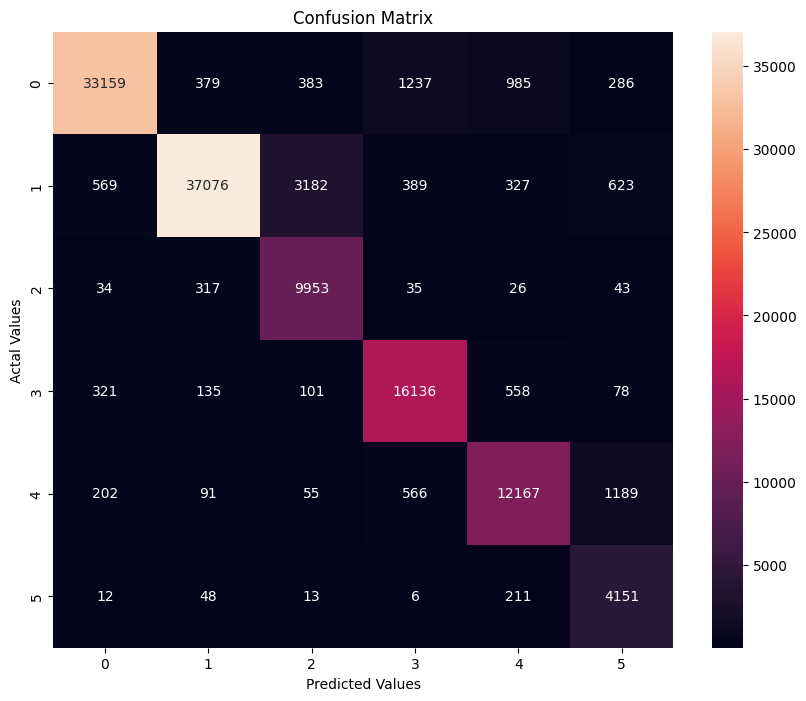

In [19]:
cm = confusion_matrix(ytest, ypred_lr_mn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [20]:
pickle.dump(lr_mn, open('../models/lr_mn_emotion_cw.pkl', 'wb'))

In [21]:
print(classification_report(ytest,ypred_lr_mn, digits=3))

              precision    recall  f1-score   support

           0      0.967     0.910     0.938     36429
           1      0.975     0.879     0.924     42166
           2      0.727     0.956     0.826     10408
           3      0.878     0.931     0.904     17329
           4      0.852     0.853     0.853     14270
           5      0.652     0.935     0.768      4441

    accuracy                          0.901    125043
   macro avg      0.842     0.911     0.869    125043
weighted avg      0.913     0.901     0.904    125043

